# Prostate Cancer Classification

In this notebook, we train a machine learning model to predict whether a patient has primary or metastatic prostate cancer on the basis of their genomic profiles (RNA sequencing). Through exploratory analysis and machine learning, we show that there is strong predictive signal for cancer state classification using normalized gene expression features. We also interpret the model and investigate the genes which are the greatest contributors to metastatic prostate cancer according to the model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data loading and preprocessing

Load TPM normalized gene expression features

In [2]:
gene_expression_df = pd.read_csv('data/P1000_data_tpm.csv', index_col='Tumor_Sample_Barcode')
print(gene_expression_df.shape)
gene_expression_df.head()

(659, 19192)


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H2BE1,GET1-SH3BGR,SPDYE15,NOTCH2NLB,SPDYE13,ASDURF,SPEGNB,SPDYE14,DERPC,NOTCH2NLC
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-EJ-5499,60.67,0.05,41.57,9.29,3.16,2.29,9.87,38.64,27.14,14.56,...,0.00,0.38,0.0,27.48,0.0,3.14,0.39,0.0,19.24,2.06
MO_1012,35.08,0.00,31.77,5.27,12.04,1.21,11.49,32.28,18.38,22.13,...,0.00,0.00,0.0,13.94,0.0,19.29,0.00,0.0,0.00,5.27
TCGA-CH-5752,9.52,0.05,40.66,9.80,3.90,1.86,5.15,65.91,19.42,23.03,...,0.09,0.17,0.0,15.34,0.0,5.40,0.78,0.0,19.91,5.42
SC_9126,9.88,0.08,82.23,8.36,40.20,6.96,17.35,49.75,115.81,34.24,...,0.00,4.43,0.0,0.00,0.0,4.55,1.25,0.0,22.58,0.23
PROS01448-6115227-SM-67ERU,20.26,0.08,53.89,10.19,6.66,0.43,1.67,54.36,58.44,32.36,...,0.00,0.20,0.0,4.98,0.0,1.20,0.17,0.0,5.18,2.05


Load cancer state labels (0 = primary cancer, 1 = metastatic cancer)

In [3]:
response = pd.read_csv('data/response_paper.csv', index_col='id')
response = response.loc[gene_expression_df.index]
print(response.shape)
response.head()

(659, 1)


,response
Tumor_Sample_Barcode,
TCGA-EJ-5499,0
MO_1012,1
TCGA-CH-5752,0
SC_9126,1
PROS01448-6115227-SM-67ERU,1


Look at distribution of the labels

In [4]:
response['response'].value_counts(normalize=True)

0    0.69044
1    0.30956
Name: response, dtype: float64

Perform train/test split

In [5]:
test_set_ids = pd.read_csv('data/test_set.csv')['id']

X_train = gene_expression_df[~gene_expression_df.index.isin(test_set_ids)]
y_train = response[~response.index.isin(test_set_ids)]['response']
X_test = gene_expression_df[gene_expression_df.index.isin(test_set_ids)]
y_test = response[response.index.isin(test_set_ids)]['response']

print("X_train dimensions:", X_train.shape)
print("y_train dimensions:", y_train.shape)
print("X_test dimensions:", X_test.shape)
print("y_test dimensions:", y_test.shape)

X_train dimensions: (592, 19192)
y_train dimensions: (592,)
X_test dimensions: (67, 19192)
y_test dimensions: (67,)


## Machine learning to classify prostate cancer state

Project gene expression matrix onto two dimensions using t-SNE to see if there is predictive signal for cancer state classification

Text(0, 0.5, 't-SNE 2')

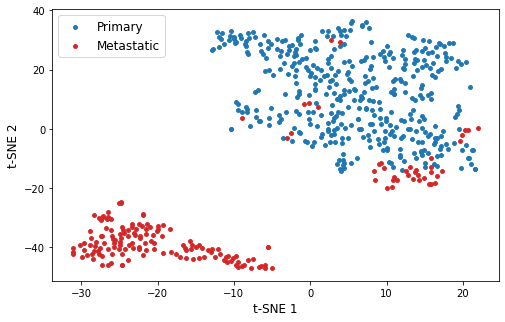

In [9]:
gene_expression_pca = PCA(n_components=20).fit_transform(X_train)
gene_expression_tsne = TSNE(n_components=2, random_state=0).fit_transform(gene_expression_pca)

plt.figure(figsize=(8, 5))
colors=['tab:blue', 'tab:red']
for i, class_ in enumerate(['Primary', 'Metastatic']):
    plt.scatter(gene_expression_tsne[y_train == i, 0], 
                gene_expression_tsne[y_train == i, 1],
                c=colors[i], s=15, label=class_)
plt.legend(fontsize=12)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)

Feature selection using mutual information between gene expression and cancer state

In [10]:
midf = pd.DataFrame({
    "feature": X_train.columns.values,
    "mi": mutual_info_classif(X_train, y_train),
}).sort_values("mi", ascending=False)

midf.head()

,feature,mi
2575,PAGE4,0.519929
12280,AR,0.516467
18536,NACA2,0.516072
18918,GTF2H5,0.511085
18862,MTRNR2L12,0.508790


Text(0.5, 0, 'Feature (gene) index')

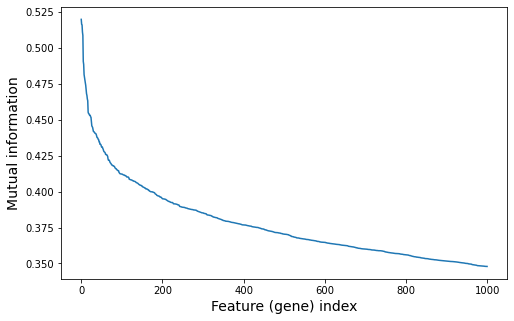

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1000), midf.mi.iloc[:1000])
plt.ylabel('Mutual information', fontsize=14)
plt.xlabel('Feature (gene) index', fontsize=14)

Filter top features based on mutual information

In [12]:
midf_cutoff = 0.4
features = midf[midf.mi > midf_cutoff]['feature']
len(features)

171

Train a prostate cancer state (primary vs metastatic) classification model

In [13]:
model = LogisticRegression()
model.fit(X_train[features], y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.idxmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score[:, 1], average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

Evaluate test set performance

In [15]:
y_pred_score = model.predict_proba(X_test[features])
y_pred = model.predict(X_test[features])
performance_scores(y_test.values, y_pred_score, y_pred)

{'accuracy': 1.0, 'balanced_accuracy': 1.0, 'auroc': 1.0, 'f1': 1.0}

Predictions and actuals are identical in the test set

In [18]:
print("Predictions:\n", y_pred)
print("\nActual:\n", y_test.values)

Predictions:
 [1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]

Actual:
 [1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0
 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


Sanity check: make sure test set instances are not contained in the training set

In [22]:
X_test.index.isin(X_train.index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

## Model interpretation

Feature importance (top 10 features)

In [23]:
model_coefs = pd.Series(index=features.values, data=model.coef_[0])
model_coefs = model_coefs.sort_values(key=abs, ascending=False)
model_coefs.head(10)

HBB      0.008636
HBA2     0.007421
RPL36   -0.006290
HSPE1    0.006089
RPL14   -0.005836
RPL19    0.005382
TFR2     0.005129
AR       0.004644
MYL9    -0.004047
PTMS     0.003832
dtype: float64

Visualize top features vs cancer state using box plots

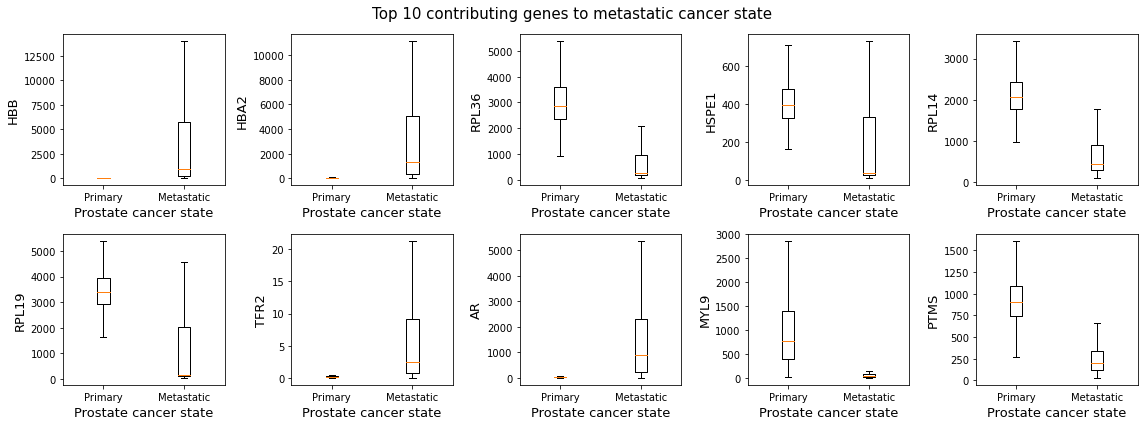

In [45]:
plt.figure(figsize=(16, 6))
top_features = model_coefs.index[:10]
for i, feature in enumerate(top_features):
    plt.subplot(2, 5, i+1)
    cancer_state_to_feature_values = {
        state: gene_expression_df.loc[response['response'] == state, feature]
    for state in [0, 1]}
    plt.boxplot(cancer_state_to_feature_values.values(), showfliers=False)
    plt.xticks([1, 2], ['Primary', 'Metastatic']);
    plt.xlabel('Prostate cancer state', fontsize=13)
    plt.ylabel(feature, fontsize=13)
plt.suptitle('Top 10 contributing genes to metastatic cancer state', fontsize=15)
plt.tight_layout()